# 2. Analyse ML avec Azure ML

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

### Données Framingham

https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset

Attributes/columns:

- male: 0 = Female; 1 = Male
- age: Age at exam time
- education: 1 = Some High School; 2 = High School or GED; 3 = Some College or Vocational School; 4 = college
- currentSmoker: 0 = nonsmoker; 1 = smoker
- cigsPerDay: number of cigarettes smoked per day (estimated average)
- BPMeds: 0 = Not on Blood Pressure medications; 1 = Is on Blood Pressure medications
- prevalentStroke
- prevalentHyp
- diabetes: 0 = No; 1 = Yes
- totChol in mg/dL
- sysBP in mmHg
- diaBP in mmHg
- BMI: Body Mass Index calculated as: Weight (kg) / Height(meter-squared)
- heartRate: Beats/Min (Ventricular)
- glucose in mg/dL

- TenYearCHD - Did the person get heart disease in the 10 years study period?
label; 0 = No for heart disease, 1 = Yes for heart disease;


In [76]:
import pandas as pd
url = ('https://raw.githubusercontent.com/retkowsky/WorkshopMLOps/master/framingham.csv')
df = pd.read_csv(url)
df.head(5)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.00,0,0.00,0.00,0,0,0,195.00,106.00,70.00,26.97,80.00,77.00,0
1,0,46,2.00,0,0.00,0.00,0,0,0,250.00,121.00,81.00,28.73,95.00,76.00,0
2,1,48,1.00,1,20.00,0.00,0,0,0,245.00,127.50,80.00,25.34,75.00,70.00,0
3,0,61,3.00,1,30.00,0.00,0,1,0,225.00,150.00,95.00,28.58,65.00,103.00,1
4,0,46,3.00,1,23.00,0.00,0,0,0,285.00,130.00,84.00,23.10,85.00,85.00,0


## 1. Informations

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print(now)

2020-03-12 09:45:21.716212


In [3]:
#Version
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.0.83


In [4]:
# Azure subscription
subscription_id = "ARENSEIGNER" 

# Resource Group 
resource_group = "MLOpsworkshopRG" 

# Workspace Name and Azure Region of the Azure Machine Learning Workspace
workspace_name = "MLOpsWorkshop" 
workspace_region = "westeurope" 

# Other variables
experiment_name = 'chd-prediction-manual'
project_dir = './chd'
deployment_dir = './deploy'
model_name = 'chd-predictor-manual'
model_description = 'Model to predict coronory heart disease'

# AML managed compute to be spun up for training
vm_name = "chd-manual"

In [5]:
import os
import logging

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.compute import ComputeTarget
from azureml.core.model import Model
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from azureml.core import Workspace
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails

## 2. Workspace Azure ML

In [6]:
ws = Workspace.create(
    name = workspace_name,
    subscription_id = subscription_id,
    resource_group = resource_group, 
    location = workspace_region,
    exist_ok = True) #Leverage existing

ws.write_config()
print('Workspace configuration succeeded')

Workspace configuration succeeded


## 3. Expérimentation Azure ML

In [7]:
experiment = Experiment(ws, experiment_name)

In [8]:
# Create project directory
if not os.path.exists(project_dir):
    os.makedirs(project_dir)

In [9]:
# Infos
from azureml.core.workspace import Workspace
ws = Workspace.from_config()
ws.get_details()

{'id': '/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/MLOpsworkshopRG/providers/Microsoft.MachineLearningServices/workspaces/MLOpsWorkshop',
 'name': 'MLOpsWorkshop',
 'location': 'westeurope',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {},
 'sku': 'Enterprise',
 'workspaceid': '0dfe6024-f582-48e0-bac6-1fe3069f1f6e',
 'description': '',
 'friendlyName': '',
 'creationTime': '2020-03-11T13:22:21.0091248+00:00',
 'containerRegistry': '/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/MLOpsworkshopRG/providers/Microsoft.ContainerRegistry/registries/mlopsworksho9c416a26',
 'keyVault': '/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourcegroups/mlopsworkshoprg/providers/microsoft.keyvault/vaults/mlopsworkshop3410838442',
 'applicationInsights': '/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourcegroups/mlopsworkshoprg/providers/microsoft.insights/components/mlopsworkshop8083740862',
 'identityPrincipalId': '8487b5

## 4. Azure ML Compute

In [10]:
# Liste des compute servers disponibles
from azureml.core.compute import ComputeTarget, AmlCompute
AmlCompute.supported_vmsizes(workspace = ws)

[{'name': 'Standard_D1_v2',
  'vCPUs': 1,
  'gpus': 0,
  'memoryGB': 3.5,
  'maxResourceVolumeMB': 51200},
 {'name': 'Standard_D2_v2',
  'vCPUs': 2,
  'gpus': 0,
  'memoryGB': 7.0,
  'maxResourceVolumeMB': 102400},
 {'name': 'Standard_D3_v2',
  'vCPUs': 4,
  'gpus': 0,
  'memoryGB': 14.0,
  'maxResourceVolumeMB': 204800},
 {'name': 'Standard_D4_v2',
  'vCPUs': 8,
  'gpus': 0,
  'memoryGB': 28.0,
  'maxResourceVolumeMB': 409600},
 {'name': 'Standard_D11_v2',
  'vCPUs': 2,
  'gpus': 0,
  'memoryGB': 14.0,
  'maxResourceVolumeMB': 102400},
 {'name': 'Standard_D12_v2',
  'vCPUs': 4,
  'gpus': 0,
  'memoryGB': 28.0,
  'maxResourceVolumeMB': 204800},
 {'name': 'Standard_D13_v2',
  'vCPUs': 8,
  'gpus': 0,
  'memoryGB': 56.0,
  'maxResourceVolumeMB': 409600},
 {'name': 'Standard_D14_v2',
  'vCPUs': 16,
  'gpus': 0,
  'memoryGB': 112.0,
  'maxResourceVolumeMB': 819200},
 {'name': 'Standard_DS1_v2',
  'vCPUs': 1,
  'gpus': 0,
  'memoryGB': 3.5,
  'maxResourceVolumeMB': 7168},
 {'name': 'Standar

In [11]:
# Provision AML managed compute 
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

try:
    compute_target = ComputeTarget(workspace=ws, name=vm_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D12_V2',
                                                           min_nodes=1, max_nodes=1)

    # create the cluster
    compute_target = ComputeTarget.create(ws, vm_name, compute_config)
    # Show output
    compute_target.wait_for_completion(show_output=True)

Found existing compute target.


In [12]:
#On visualise que le compute server a bien été supprimé
cts = ws.compute_targets
for ct in cts:
    print(ct)

chdinf01
chd-manual
chd-temp-compute


## 5. Environnement

In [13]:
# Create Docker based environment with scikit-learn installed
training_venv = Environment("training_venv")

training_venv.docker.enabled = True
training_venv.python.conda_dependencies = CondaDependencies.create(conda_packages=['scikit-learn'])

In [14]:
%%writefile $project_dir/train.py

# Load necessary packages
import pandas as pd
import numpy as np
import pickle
import os

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Read training dataset into pandas dataframe
# Replace with your dataset URL
dataset_url = ('https://raw.githubusercontent.com/retkowsky/WorkshopMLOps/master/framingham.csv')
df = pd.read_csv(dataset_url)

# create a boolean array of smokers
smoke = (df['currentSmoker']==1)
# Apply mean to NaNs in cigsPerDay but using a set of smokers only
df.loc[smoke,'cigsPerDay'] = df.loc[smoke,'cigsPerDay'].fillna(df.loc[smoke,'cigsPerDay'].mean())

# Fill out missing values
df['BPMeds'].fillna(0, inplace = True)
df['glucose'].fillna(df.glucose.mean(), inplace = True)
df['totChol'].fillna(df.totChol.mean(), inplace = True)
df['education'].fillna(1, inplace = True)
df['BMI'].fillna(df.BMI.mean(), inplace = True)
df['heartRate'].fillna(df.heartRate.mean(), inplace = True)

# Features and label
features = df.iloc[:,:-1]
result = df.iloc[:,-1] # the last column is what we are about to forecast

# Train & Test split
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.2, random_state = 14)

# RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)

# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.12
sfm = SelectFromModel(clf, threshold=0.12)

# Train the selector
sfm.fit(X_train, y_train)

# Features selected
feat_labels = list(features.columns.values) # creating a list with features' names
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

# Feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# With only imporant features. Can check X_important_train.shape[1]
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, y_train)

# Save the model to disk
os.makedirs('./outputs/model', exist_ok=True)

filename = './outputs/model/chd-rf-model'
pickle.dump(clf_important, open(filename, 'wb'))
print("model saved in ././outputs/model/chd-rf-model folder")
print("Saving model completed")

Overwriting ./chd/train.py


## 6. Run

In [15]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import DEFAULT_CPU_IMAGE

src = ScriptRunConfig(source_directory=project_dir, script='train.py')

# Set compute target to the one created in previous step
src.run_config.target = compute_target.name

# Set environment
src.run_config.environment = training_venv
 
run = experiment.submit(config=src)
run

Experiment,Id,Type,Status,Details Page,Docs Page
chd-prediction-manual,chd-prediction-manual_1584006333_c6713a75,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


> Prévoir 2 minutes de temps de traitement

In [16]:
# Shows output of the run on stdout
#run.wait_for_completion(show_output=True)

### Widget pour suivre l'avancement du run

In [17]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Pour suivre l'avancement du run

In [26]:
run.get_details()

{'runId': 'chd-prediction-manual_1584006333_c6713a75',
 'target': 'chd-manual',
 'status': 'Completed',
 'startTimeUtc': '2020-03-12T09:45:49.501475Z',
 'endTimeUtc': '2020-03-12T09:47:21.599154Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '2f35c991-8670-41fd-ba51-8450c7c77299',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'chd-manual',
  'dataReferences': {},
  'data': {},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': 'training_venv',
   'version': 'Autosave_2020-03-11T13:41:26Z_1d611ccb',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': False,
    'condaDependencies': {'channels': ['conda-forge']

In [27]:
# Statut du compute server
compute_target.list_nodes()

[{'nodeId': 'tvmps_dc3a2f383a7af4fb5d7a759491c0c5e7e4fa7b77b2e2ad8496a1d7c3845b9003_d',
  'port': 50000,
  'publicIpAddress': '51.136.80.59',
  'privateIpAddress': '10.0.0.4',
  'nodeState': 'idle'}]

In [28]:
#get_status () gets the latest status of the AmlCompute target
compute_target.get_status().serialize()

{'currentNodeCount': 1,
 'targetNodeCount': 1,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 1,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2020-03-11T13:40:38.148000+00:00',
 'errors': None,
 'creationTime': '2020-03-11T13:35:47.122058+00:00',
 'modifiedTime': '2020-03-11T13:36:03.446032+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 1,
  'maxNodeCount': 1,
  'nodeIdleTimeBeforeScaleDown': ''},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_D12_V2'}

## 7. Référencement du modèle avec Azure ML

In [29]:
if run.get_status() == 'Completed':
    print("Training completed successfully!")
    model_run = run.register_model(model_name=model_name,  
                               model_path="././outputs/model/chd-rf-model",
                               tags={"type": "classification", "description": model_description, "run_id": run.id})
    print("Model registered with version number: ", model_run.version)
else:
    print("Training failed!")
    Exception("Training failed!")
    

Training completed successfully!
Model registered with version number:  4


### Liste des modèles référencés

In [30]:
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, 'Version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

chd-predictor-manual Version = 4
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-manual_1584006333_c6713a75


chd-predictor Version = 5
	 type : classification
	 run_id : 12b1a962-e311-434d-938f-2a01747d367a
	 build_number : 20200312.1


AutoMLmodele Version = 3
	 Training context : Azure Auto ML
	 NMAE : 0.14354865921496757
	 RMSE : 0.3459320040319874


AutoMLmodele Version = 2
	 Training context : Azure Auto ML
	 NMAE : 0.14663329527456334
	 RMSE : 0.34802598722645756


AutoMLmodele Version = 1
	 Training context : Azure Auto ML
	 R2 : 0.05709622765570018
	 RMSE : 0.34802598722645756


chd-predictor-manual Version = 3
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-manual_1584002248_1e3a16fa


chd-predictor-manual Version = 2
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-manual_1584001102_0049298c


chd-predict

In [31]:
experiment

Name,Workspace,Report Page,Docs Page
chd-prediction-manual,MLOpsWorkshop,Link to Azure Machine Learning studio,Link to Documentation


## 7. AutoML avec Azure ML

https://docs.microsoft.com/en-us/azure/machine-learning/concept-automated-ml

<img src="https://docs.microsoft.com/en-us/azure/machine-learning/media/concept-automated-ml/automl-concept-diagram2.png">

> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train

In [32]:
import pandas as pd
dataset_url = ('https://raw.githubusercontent.com/retkowsky/WorkshopMLOps/master/framingham.csv')
df = pd.read_csv(dataset_url)

In [33]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.00,0,0.00,0.00,0,0,0,195.00,106.00,70.00,26.97,80.00,77.00,0
1,0,46,2.00,0,0.00,0.00,0,0,0,250.00,121.00,81.00,28.73,95.00,76.00,0
2,1,48,1.00,1,20.00,0.00,0,0,0,245.00,127.50,80.00,25.34,75.00,70.00,0
3,0,61,3.00,1,30.00,0.00,0,1,0,225.00,150.00,95.00,28.58,65.00,103.00,1
4,0,46,3.00,1,23.00,0.00,0,0,0,285.00,130.00,84.00,23.10,85.00,85.00,0


In [34]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.00,4240.00,4135.00,4240.00,4211.00,4187.00,4240.00,4240.00,4240.00,4190.00,4240.00,4240.00,4221.00,4239.00,3852.00,4240.00
mean,0.43,49.58,1.98,0.49,9.01,0.03,0.01,0.31,0.03,236.70,132.35,82.90,25.80,75.88,81.96,0.15
std,0.50,8.57,1.02,0.50,11.92,0.17,0.08,0.46,0.16,44.59,22.03,11.91,4.08,12.03,23.95,0.36
min,0.00,32.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,107.00,83.50,48.00,15.54,44.00,40.00,0.00
25%,0.00,42.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,117.00,75.00,23.07,68.00,71.00,0.00
50%,0.00,49.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,234.00,128.00,82.00,25.40,75.00,78.00,0.00
75%,1.00,56.00,3.00,1.00,20.00,0.00,0.00,1.00,0.00,263.00,144.00,90.00,28.04,83.00,87.00,0.00
max,1.00,70.00,4.00,1.00,70.00,1.00,1.00,1.00,1.00,696.00,295.00,142.50,56.80,143.00,394.00,1.00


In [35]:
df.corr()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1.00,-0.03,0.02,0.20,0.32,-0.05,-0.00,0.01,0.02,-0.07,-0.04,0.06,0.08,-0.12,0.01,0.09
age,-0.03,1.00,-0.17,-0.21,-0.19,0.12,0.06,0.31,0.10,0.26,0.39,0.21,0.14,-0.01,0.12,0.23
education,0.02,-0.17,1.00,0.02,0.01,-0.01,-0.04,-0.08,-0.04,-0.02,-0.13,-0.06,-0.14,-0.05,-0.04,-0.05
currentSmoker,0.20,-0.21,0.02,1.00,0.77,-0.05,-0.03,-0.10,-0.04,-0.05,-0.13,-0.11,-0.17,0.06,-0.06,0.02
cigsPerDay,0.32,-0.19,0.01,0.77,1.00,-0.05,-0.03,-0.07,-0.04,-0.03,-0.09,-0.06,-0.09,0.08,-0.06,0.06
BPMeds,-0.05,0.12,-0.01,-0.05,-0.05,1.00,0.12,0.26,0.05,0.08,0.25,0.19,0.10,0.02,0.05,0.09
prevalentStroke,-0.00,0.06,-0.04,-0.03,-0.03,0.12,1.00,0.07,0.01,0.00,0.06,0.05,0.03,-0.02,0.02,0.06
prevalentHyp,0.01,0.31,-0.08,-0.10,-0.07,0.26,0.07,1.00,0.08,0.16,0.70,0.62,0.30,0.15,0.09,0.18
diabetes,0.02,0.10,-0.04,-0.04,-0.04,0.05,0.01,0.08,1.00,0.04,0.11,0.05,0.09,0.05,0.62,0.10
totChol,-0.07,0.26,-0.02,-0.05,-0.03,0.08,0.00,0.16,0.04,1.00,0.21,0.16,0.12,0.09,0.05,0.08


In [36]:
df.shape

(4240, 16)

## Paramétrage AutoML

> https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train

In [37]:
# Variable à modéliser
targetvariable ="TenYearCHD"

Text(0.5, 1.0, 'Variable TenYearCHD (1 = Heart Disease, 0 = No Heart Disease)')

<Figure size 720x360 with 0 Axes>

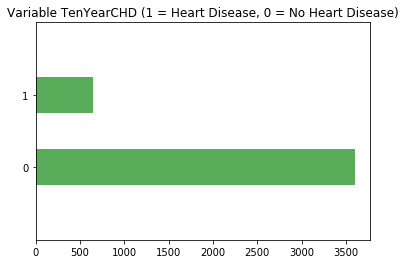

In [65]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
df.TenYearCHD.value_counts().plot(kind='barh', color="green", alpha=.65)
ax.set_ylim(-1, len(df.TenYearCHD.value_counts())) 
plt.title("Variable TenYearCHD (1 = Heart Disease, 0 = No Heart Disease)")

In [61]:
automl_settings = {
    "enable_early_stopping": True,
    "iterations" : 10,                          #20 itérations max
    "iteration_timeout_minutes" : 2,            #Temps max par itération
    "experiment_timeout_minutes" : 10,          #Temps max pour le process AutoML
    "n_cross_validations": 5,                   #Validation croisée
    "primary_metric": 'accuracy',               #Choix de la métrique
    "verbosity": logging.INFO
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl.log',
                             preprocess=True,
                             training_data = df,
                             label_column_name = targetvariable,
                             **automl_settings
                            )

In [62]:
automl_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_54d567dc-93c7-4869-938c-4f07d30f5ae4

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Classes are balanced in the training data.

TYPE:         Missing values imputation
STATUS:       FIXED
DESCRIPTION:  The training data had the following missing values which were resolved. Please review your data source for data quality issues and possibly filter out the rows with these missing values. If the missing values are exp

In [66]:
automl_run

Experiment,Id,Type,Status,Details Page,Docs Page
chd-prediction-manual,AutoML_54d567dc-93c7-4869-938c-4f07d30f5ae4,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [67]:
# Widget
from azureml.widgets import RunDetails
RunDetails(automl_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [68]:
children = list(automl_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
AUC_macro,0.65,0.69,0.70,0.66,0.70,0.68,0.70,0.67,0.70,0.70
AUC_micro,0.88,0.89,0.73,0.67,0.90,0.72,0.90,0.69,0.90,0.89
AUC_weighted,0.65,0.69,0.70,0.66,0.70,0.68,0.70,0.67,0.70,0.70
accuracy,0.84,0.84,0.67,0.67,0.84,0.67,0.85,0.66,0.85,0.83
average_precision_score_macro,0.59,0.61,0.62,0.59,0.61,0.61,0.61,0.59,0.62,0.62
average_precision_score_micro,0.87,0.88,0.72,0.62,0.89,0.72,0.89,0.67,0.89,0.89
average_precision_score_weighted,0.81,0.82,0.83,0.81,0.83,0.82,0.83,0.82,0.83,0.83
balanced_accuracy,0.53,0.53,0.66,0.62,0.51,0.63,0.51,0.62,0.52,0.52
f1_score_macro,0.53,0.52,0.57,0.55,0.48,0.56,0.49,0.55,0.49,0.49
f1_score_micro,0.84,0.84,0.67,0.67,0.84,0.67,0.85,0.66,0.85,0.83


### Best Model

In [69]:
best_run, fitted_model = automl_run.get_output()
print(best_run)
print(fitted_model)
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

Run(Experiment: chd-prediction-manual,
Id: AutoML_54d567dc-93c7-4869-938c-4f07d30f5ae4_8,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...142857142855, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]))])
AUC_macro 0.7003803599056947
AUC_micro 0.8999407596119615
f1_score_macro 0.49467419062103424
accuracy 0.8502358490566039
precision_score_weighted 0.8347551045528394
average_precision_score_weighted 0.8318009923726963
confusion_matrix aml://artifactId/ExperimentRun/dcid.AutoML_54d567dc-93c7-4869-938c-4f07d30f5ae4_8/confusion_matrix
average_precision_score_micro 0.8911487049444531
log_loss 0.4044577886647381
AUC_weighted 0.7003803599056947
f1_sc

In [70]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...142857142855, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]))])>

In [71]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
          feature_sweeping_config=None, feature_sweeping_timeout=None,
          featurization_config=None, force_text_dnn=None,
          is_cross_validation=None, is_onnx_compatible=None, logger=None,
          observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=None,
                 estimators=[('6', Pipeline(memory=None,
       steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('sgdclassifierwrapper', SGDClassifierWrapper(alpha=3.46945306122449, class_weight='balanced',
             eta0=0.01, fit_intercept=True, l1_ratio=0.7755102040816326,
             learning_rate='constant', lo...ators=25, n_jobs=1,
              oob_score=True, random_state=None, verbose=0, warm_start=False))]))],
                 flatten_transform=None,
                 weights=[0.42857142857142855, 0.14285714285714285, 0.14285714285714285, 

### Référencement du meilleur modèle

In [72]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='AutoMLmodele',
                        tags={'Training context':'Azure Auto ML'},
                        properties={'Accuracy': best_run_metrics['accuracy'], 'AUC': best_run_metrics['AUC_weighted']})

Model(workspace=Workspace.create(name='MLOpsWorkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='MLOpsworkshopRG'), name=AutoMLmodele, id=AutoMLmodele:5, version=5, tags={'Training context': 'Azure Auto ML'}, properties={'Accuracy': '0.8502358490566039', 'AUC': '0.7003803599056947'})

### Liste des modèles référencés

In [73]:
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, 'Version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

AutoMLmodele Version = 5
	 Training context : Azure Auto ML
	 Accuracy : 0.8502358490566039
	 AUC : 0.7003803599056947


AutoMLmodele Version = 4
	 Training context : Azure Auto ML
	 Accuracy : 0.8523584905660379
	 AUC : 0.7011713285042245


chd-predictor-manual Version = 4
	 type : classification
	 description : Model to predict coronory heart disease
	 run_id : chd-prediction-manual_1584006333_c6713a75


chd-predictor Version = 5
	 type : classification
	 run_id : 12b1a962-e311-434d-938f-2a01747d367a
	 build_number : 20200312.1


AutoMLmodele Version = 3
	 Training context : Azure Auto ML
	 NMAE : 0.14354865921496757
	 RMSE : 0.3459320040319874


AutoMLmodele Version = 2
	 Training context : Azure Auto ML
	 NMAE : 0.14663329527456334
	 RMSE : 0.34802598722645756


AutoMLmodele Version = 1
	 Training context : Azure Auto ML
	 R2 : 0.05709622765570018
	 RMSE : 0.34802598722645756


chd-predictor-manual Version = 3
	 type : classification
	 description : Model to predict coronory heart 

### Accès expérimentation Azure ML

In [74]:
experiment

Name,Workspace,Report Page,Docs Page
chd-prediction-manual,MLOpsWorkshop,Link to Azure Machine Learning studio,Link to Documentation


> Fin